# LEFT PRECONDITIONED GMRES

In [3]:
import numpy as np
import time
import scipy
import scipy.sparse.linalg as spla
from scipy.sparse.linalg import spsolve_triangular as triang
from scipy.sparse import tril, diags, eye
from scipy.sparse.linalg import inv
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix, coo_matrix

We use b in the stopping criteria to compare our implementation with the scipy implementation

In [5]:
def arnoldi_one_iter(prec, A, V, k, tol=1e-14):
    """
    Computes the new vectors of the Arnoldi iteration for both V_{k+1} and H_{k+1, k}

    Input parameters:
    -----------------

    prec: function
        A preconditioner function or an identity function. It is used to improve the convergence
        of the Arnoldi iteration. If no preconditioning is needed, an identity function can be used.

    A: array_like
        An (n x n) array representing the matrix for which we are building the Krylov subspace.

    V: array_like
        An (n x (k + 1)) array. The current Krylov orthonormal basis.

    k: int
        One less than the step we are obtaining in the Arnoldi's algorithm to increase
        the dimension of the Krylov subspace. Must be >= 0.

    tol: float, optional
        Tolerance for convergence.

    Output:
    -------
    h_k: array_like
        A 1D array of size (k + 2,). Represents the column k of the Hessenberg matrix H.
        Contains the coefficients of the projections of v_new onto the existing orthonormal basis vectors.

    v_new: array_like or None
        A 1D array of size (n,). Represents the new orthonormal vector added to the Krylov subspace basis V.
        If convergence is achieved within the given tolerance, v_new is set to None.
    """
    # Note that to obtain the first column of H ((k + 1) x k) we need 2 vectors in V. Later in the GMRES algorithm
    # we will use the notation H[:k + 2, :k + 1] as k starts at 0 and we select the first two rows and first column.
    
    # Here h_k represents the column k in H. (k starts at 0)
    
    # Initialize k + 2 nonzero elements of H along column k. (k starts at 0)
    h_k = np.zeros((k + 2, ))

    v_new = prec(A @ V[:, k])
    
    # Calculate first k elements of the kth Hessenberg column
    for j in range(k + 1): # Here k is from 0 to k 
        h_k[j] = v_new @ V[:, j]
        v_new = v_new - h_k[j] * V[:, j]
    
    # Add the k+1 element
    h_k[k + 1] = np.linalg.norm(v_new)

    if h_k[k + 1] <= tol:
        # None for v to check in gmres (early termination with EXACT SOLUTION)
        return h_k, None
    
    else:
        # Find the new orthogonal vector in the basis of the Krylov subspace
        v_new = v_new / h_k[k + 1]

    return h_k, v_new

    
def back_substitution(A, b):
    """
    Solve a linear system using back substitution.
    
    Args:
    ----------
        A: list of lists
            Coefficient matrix (must be upper triangular).
        
        b: list
            Column vector of constants.
    
    Returns:
    --------
        list: Solution vector.
        
    Raises:
        ValueError: If the matrix A is not square or if its dimensions are incompatible with the vector b.
    """
    
    n = len(b)
    
    # Check if A is a square matrix
    if len(A) != n or any(len(row) != n for row in A):
        raise ValueError("Matrix A must be square.")
    
    # Check if dimensions of A and b are compatible
    if len(A) != len(b):
        raise ValueError("Dimensions of A and b are incompatible.")
    
    x = [0] * n
    
    for i in range(n - 1, -1, -1):
        x[i] = (b[i] - sum(A[i][j] * x[j] for j in range(i + 1, n))) / A[i][i]
    
    return x

In [7]:
import numpy as np
from numpy.linalg import qr

def precon_GMRES_restarted(prec, A, b, x0 = None, k_max = None, restart = None, epsilon = 1e-12):
    """
    Generalized Minimal RESidual method for solving linear systems. With both restart and left preconditioning options.
    
    Parameters:
    -----------
    prec: preconditioner function
    
    A : torch.Tensor
        Coefficient matrix of the linear system.
        
    b : torch.Tensor
        Right-hand side vector of the linear system.
        
    x0 : torch.Tensor
        Initial guess for the solution.
        
    k_max : int, optional
        Maximum number of iterations. Defaults to None, which sets it to the dimension of A.
        
    restart : int, optional
        Number of iterations before restart. If None, the method will not restart.
    
    epsilon : float, optional
        Tolerance for convergence. Defaults to 1e-12.
    
    Returns:
    --------
    xk : torch.Tensor
        Approximate solution to the linear system.
    
    error_list : list
        List containing the error at each iteration.
    
    total_k : int
        Total number of iterations performed.
        
    total_precondition_time : float
        Total time spent on preconditioning.
    """
    
    x0 = x0 if x0 is not None else np.zeros_like(b)
    
    n = A.shape[0]
    
    if k_max is None or k_max > n:
        k_max = n
    
    r0 = b - A@x0
    
    # Apply initial preconditioning to the residual
    r0 = prec(r0)

    p0 = np.linalg.norm(r0)
    beta = p0
    pk = p0
    k = 0
    total_k = 0
    
    # Save list of errors at each iteration
    error_list = [pk]
    
    # Initialize the V basis of the Krylov subspace (concatenate as iteration continues). May terminate early.
    V = np.zeros((n, 1))
    V[:, 0] = r0 / beta
    
    # Hessenberg matrix
    H = np.zeros((n + 1, 1))        
    
    while pk > epsilon * np.linalg.norm(b) and total_k < k_max:

        # Arnoldi iteration
        V = np.concatenate((V, np.zeros((n, 1))), axis=1)
        H = np.concatenate((H, np.zeros((n + 1, 1))), axis=1)
        
        # Minv_A will be A if precondition is None
        H[:k + 2, k], v_new = arnoldi_one_iter(prec, A, V, k)

        if v_new is None:
            print("ENCOUNTER EXACT SOLUTION")
            # Append 0 for plots...
            error_list.append(0)
            Q, R = qr(H[:k + 2, :k + 1], mode = 'complete')
        
            pk = abs(beta * Q[0, k])  # Compute norm of residual vector
            error_list.append(pk)  # Add new error at current iteration       
        
            yk = back_substitution(R[:-1, :], beta * Q[0][:-1])
            xk = x0 + V[:, :k + 1] @ yk  # Compute the new approximation x0 + V_{k}y
            
            k += 1
            total_k += 1
            
            break
        
        else:
            V[:, k + 1] = v_new
        
        Q, R = qr(H[:k + 2, :k + 1], mode = 'complete')
        
        pk = abs(beta * Q[0, k])  # Compute norm of residual vector
        error_list.append(pk)  # Add new error at current iteration       
        
        yk = back_substitution(R[:-1, :], beta * Q[0][:-1])
        xk = x0 + V[:, :k + 1] @ yk  # Compute the new approximation x0 + V_{k}y

        k += 1
        total_k += 1
        
        if restart is not None and k == restart:
            x0 = xk
            r0 = b - A @ x0
            
            r0 = prec(r0)
            
            p0 = np.linalg.norm(r0)
            beta = p0
            pk = p0
            k = 0
            
            V = np.zeros((n, 1))
            V[:, 0] = r0 / beta
            H = np.zeros((n + 1, 1))
  
    return xk, error_list, total_k

In [14]:
import numpy as np
import time
import ilupp
import scipy.sparse
from scipy.sparse.linalg import spsolve_triangular as triang
from scipy.sparse import tril, triu, diags, eye
from scipy.sparse.linalg import spsolve, inv
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
from scipy import sparse

def fb_solve(L, U, r):
    y = triang(L, r, lower = True)
    z = triang(U, y, lower = False)
    return z

time_function = lambda: time.perf_counter()

def preconditioner(method, A, model = None, data = None):
    
    n = A.shape[0]

    if method == "baseline":

        p_start, p_stop = 0, 0

        prec = lambda x: x
    
    elif method == "jacobi":
        p_start = time_function()
        
        diag = A.diagonal()
        M = csr_matrix((1/diag, (range(n), range(n))), shape=(n,n))

        # construct preconditioner function
        prec = lambda x: M@x

        p_stop = time_function()
        
    elif method == "gaussseidel":
        p_start = time_function()

        # Extract diagonal part of A
        D = diags(A.diagonal())

        # Extract strictly lower triangular part of A
        L = tril(A, k=-1, format="csr")

        # Construct the Gauss-Seidel preconditioner
        M = triang(D - L, np.eye(D.shape[0]))
        
        M = sparse.csr_matrix(M)
        
        prec = lambda x: M@x

        p_stop = time_function()

    elif method == "symmetricgaussseidel":
        p_start = time_function()

        D_vector = A.diagonal()
        D_inv_vector = 1 / D_vector
        D_inv = diags(D_inv_vector, offsets = 0, format="csr")

        L = eye(n) + tril(A, k = -1, format = "csr") @ D_inv
        U = triu(A, format = "csr") 

        prec = lambda x: fb_solve(L, U, x)

        p_stop = time_function()
    
    elif method == "ilu":

        p_start = time_function()

        B = ilupp.ILU0Preconditioner(A)
        L, U = B.factors()
        p_stop = time_function()

        prec = lambda x: fb_solve(L, U, x)

    elif method == "learned":
        
        data = data.to("cpu")
        p_start = time_function()

        # matrices obtained from forward pass through the model
        L, U = model(data)

        L = L.coalesce()
        data = L.values().numpy()
        indices = L.indices().numpy()
        shape = L.size()
        L = coo_matrix((data, indices), shape=shape).tocsr()

        U = U.coalesce()
        data = U.values().numpy()
        indices = U.indices().numpy()
        shape = U.size()
        U = coo_matrix((data, indices), shape=shape).tocsr()


        L = sparse.csr_matrix(L)
        U = sparse.csr_matrix(U)

        prec = lambda x : fb_solve(L, U, x)

        p_stop = time_function()

    else:
        raise NotImplementedError(f"Preconditioner {method} not implemented!")       
        
    total_time = p_stop - p_start
    return prec, total_time


# Unit tests

## Test 1: Comparing against scipy, basic example

In [9]:
# Define the numpy array
A = np.array([[1, 1, 4, 9], [3, 4, 6, 9], [4, 1, 1, 3], [3, 2, 1, 1]])
b = np.array([3, 2, 2, -3])
x0 = np.zeros_like(b)

x1 = spla.gmres(A, b, x0, restart = None)[0]

prec,_ = preconditioner("baseline", A)

x2, _, _ = precon_GMRES_restarted(prec, A, b)
print (x1, x2)

ENCOUNTER EXACT SOLUTION
[ 2.96296296 -9.44444444 10.7037037  -3.7037037 ] [ 2.96296296 -9.44444444 10.7037037  -3.7037037 ]


## Test 2: Comparing SciPy implementation and our implementation in a matrix arised from a structural problem

https://sparse.tamu.edu/HB/bcsstk18

**Problem type:** structural problem - S STIFFNESS MATRIX arised from R.E.GINNA NUCLEAR POWER STATION

**Dimension:** 11,948 x 11,948

**Nonzero elements:** 149,090

**Condition number:** 3.459995e+11

In [15]:
import scipy.io
import scipy.sparse
from scipy.sparse.linalg import gmres

# Load the .mtx file
A = scipy.io.mmread("data/bcsstk18.mtx")

# Convert the matrix to CRS format
A = scipy.sparse.csr_matrix(A)

b = np.ones(A.shape[0])

x0 = np.zeros(b.size)

maxiter = 10000
restart = 20

start_time = time.time()
x, iterations = gmres(A, b, x0, restart = 20, maxiter = int(maxiter/restart))
residual_calculated1 = np.linalg.norm(A@x - b)
end_time = time.time()
print("SciPy GMRES Time:", end_time - start_time)

print(f"Calculated Scipy residual with Ax-b (max_iterations = {maxiter}, restart = {restart}): {residual_calculated1}")

prec, prectime  = preconditioner("baseline", A)

start_time = time.time()
x, _, itera = precon_GMRES_restarted(prec, A, b, x0, k_max = maxiter, restart = restart)
residual_calculated2 = np.linalg.norm(A@x - b)
end_time = time.time()
print("Optimized GMRES_restarted Time:", end_time - start_time)

print(f"Our implementation residual (baseline) with Ax-b (max_iterations = {maxiter}, restart = {restart}): {residual_calculated2}")

prec, prectime  = preconditioner("ilu", A)

start_time = time.time()
x, _, itera = precon_GMRES_restarted(prec, A, b, x0, k_max = maxiter, restart = restart)
residual_calculated2 = np.linalg.norm(A@x - b)
end_time = time.time()
print("Optimized GMRES_restarted Time:", end_time - start_time)

print(f"Our implementation residual (ilu) with Ax-b (max_iterations = {maxiter}, restart = {restart}): {residual_calculated2}")

SciPy GMRES Time: 6.741053104400635
Calculated Scipy residual with Ax-b (max_iterations = 10000, restart = 20): 70.57320001934336
Optimized GMRES_restarted Time: 20.179197072982788
Our implementation residual (baseline) with Ax-b (max_iterations = 10000, restart = 20): 70.57320020880756
Optimized GMRES_restarted Time: 44.74584197998047
Our implementation residual (ilu) with Ax-b (max_iterations = 10000, restart = 20): 0.24711896378110979


## Test 3: Comparing different restart values

Residual without restarting and 200 iterations (dim A): 1.234777961950466e-13


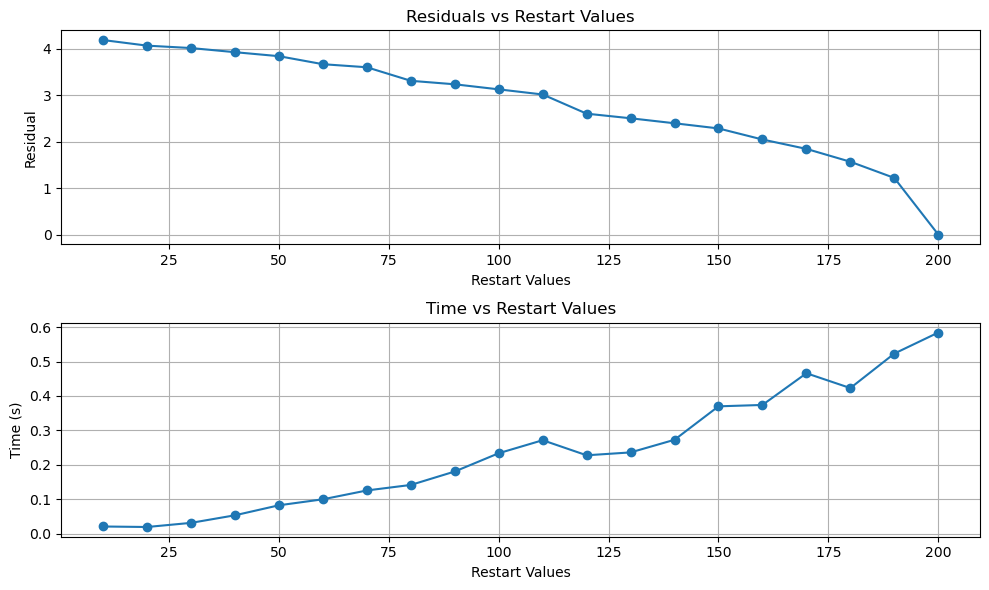

In [26]:
import matplotlib.pyplot as plt
from scipy.sparse import random

def generate_sparse_matrix(n, density=0.1):
    """
    Generate a random sparse matrix.
    
    Parameters:
    -----------
    n : int
        Size of the matrix.
        
    density : float, optional
        Density of non-zero elements.
        
    Returns:
    --------
    scipy.sparse.csr_matrix
        Random sparse matrix.
    """
    return random(n, n, density = density, format='csr')

def compare_restart_values(n, density=0.1, k_max=None, restart_values=[None, 5, 10, 20]):
    """
    Compare different restart values for GMRES restarted method.
    
    Parameters:
    -----------
    n : int
        Size of the matrix.
        
    density : float, optional
        Density of non-zero elements in the sparse matrix.
        
    k_max : int, optional
        Maximum number of iterations.
        
    restart_values : list, optional
        List of restart values to compare.
        
    epsilon : float, optional
        Tolerance for convergence.
    """
    A = generate_sparse_matrix(n, density)
    b = np.random.rand(n)
    x0 = np.zeros_like(b)
    
    residuals = []
    times = []
    
    prec, _  = preconditioner("baseline", A)

    for restart in restart_values:
        start_time = time.time()
        sol, _, _ = precon_GMRES_restarted(prec, A, b, x0, k_max = k_max, restart = restart)
        end_time = time.time()
        residual = np.linalg.norm(A@sol - b)
        residuals.append(residual)
        times.append(end_time - start_time)
    
    sol, _, _ = precon_GMRES_restarted(prec, A, b, x0, k_max = None, restart = None)
    residual = np.linalg.norm(A@sol - b)
    print("Residual without restarting and 200 iterations (dim A):", residual)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    
    # Plot for residuals
    plt.subplot(2, 1, 1)
    plt.plot(restart_values, residuals, marker='o')
    plt.title('Residuals vs Restart Values')
    plt.xlabel('Restart Values')
    plt.ylabel('Residual')
    plt.grid(True)
    
    # Plot for time
    plt.subplot(2, 1, 2)
    plt.plot(restart_values, times, marker='o')
    plt.title('Time vs Restart Values')
    plt.xlabel('Restart Values')
    plt.ylabel('Time (s)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

compare_restart_values(200, density = 0.1, k_max = None, restart_values=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200])

## Test 4: Poisson problem in the unit square $\Omega = [0,1]^2$ with $x=0$ in $\partial\Omega$.

In [18]:
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix

def discretise_poisson(N):
    """Generate the matrix and rhs associated with the discrete Poisson operator."""
    
    nelements = 5 * N**2 - 16 * N + 16
    
    row_ind = np.empty(nelements, dtype=np.float64)
    col_ind = np.empty(nelements, dtype=np.float64)
    data = np.empty(nelements, dtype=np.float64)
    
    f = np.empty(N * N, dtype=np.float64)
    
    count = 0
    for j in range(N):
        for i in range(N):
            if i == 0 or i == N - 1 or j == 0 or j == N - 1:
                row_ind[count] = col_ind[count] = j * N + i
                data[count] =  1
                f[j * N + i] = 0
                count += 1
                
            else:
                row_ind[count : count + 5] = j * N + i
                col_ind[count] = j * N + i
                col_ind[count + 1] = j * N + i + 1
                col_ind[count + 2] = j * N + i - 1
                col_ind[count + 3] = (j + 1) * N + i
                col_ind[count + 4] = (j - 1) * N + i
                                
                data[count] = 4 * (N - 1)**2
                data[count + 1 : count + 5] = - (N - 1)**2
                f[j * N + i] = 1
                
                count += 5
                                                
    return coo_matrix((data, (row_ind, col_ind)), shape=(N**2, N**2)), f

In [19]:
N = 100

A, b = discretise_poisson(N)

A.shape, b.shape

((10000, 10000), (10000,))

In [20]:
A = csr_matrix(A)

nbytes = A.data.nbytes + A.indices.nbytes + A.indptr.nbytes
print(f"The matrix A uses {round(nbytes / 1024**2, 2)} MB Ram.")

The matrix A uses 0.59 MB Ram.


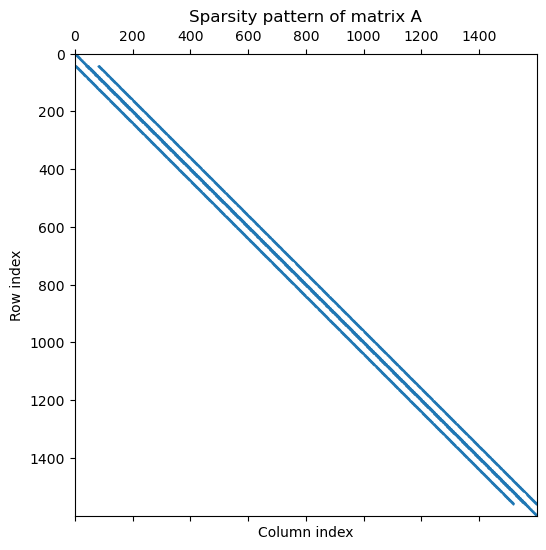

In [21]:
import matplotlib.pyplot as plt

N = 40

A, b = discretise_poisson(N)

# Plot the sparsity pattern of matrix A
plt.figure(figsize=(6, 6))
plt.spy(A, markersize=0.5)
plt.title("Sparsity pattern of matrix A")
plt.xlabel("Column index")
plt.ylabel("Row index")
plt.show()

In [23]:
x0 = np.zeros(N*N)

# Parameters
k_max = 100
epsilon = 1e-12

prec, prectime  = preconditioner("baseline", A)

x1, _, itera = precon_GMRES_restarted(prec, A, b, x0, k_max = k_max, restart = 10)


residual = np.linalg.norm(A@x1 - b)

print("Our implementation residual with Ax-b (restart = 10):", residual)

x2, _, itera = precon_GMRES_restarted(prec, A, b, x0, k_max = k_max, restart = 20)

residual = np.linalg.norm(A@x2 - b)

print("\nOur implementation residual with Ax-b (restart = 20):", residual)

x3, _, itera = precon_GMRES_restarted(prec, A, b, x0, k_max = k_max, restart = 50)

residual = np.linalg.norm(A@x3 - b)

print("\nOur implementation residual with Ax-b (restart = 50):", residual)

Our implementation residual with Ax-b (restart = 10): 1.3771604131809796

Our implementation residual with Ax-b (restart = 20): 0.12100952523471921

Our implementation residual with Ax-b (restart = 50): 2.227319889827748e-07


## Test 5: Random sparse matrices with $n$ = 1000

In [15]:
def jacobi_preconditioner(A):
    n = A.shape[0]
    diag = A.diagonal()
    M = csr_matrix((1/diag, (range(n), range(n))), shape=(n,n))
    return M

In [29]:
from scipy.sparse.linalg import gmres

random_state = 0
rng = np.random.RandomState(random_state)

n = 1000
zero_prob = rng.uniform(0.995, 0.999)
nnz = int((1 - zero_prob) * n ** 2)
rows = [rng.randint(0, n) for _ in range(nnz)]
cols = [rng.randint(0, n) for _ in range(nnz)]

uniques = set(zip(rows, cols)) # Ensure we do not have repeated edges
rows, cols = zip(*uniques)

# generate values
vals = np.array([rng.normal(0, 1) for _ in cols]) # Random values are generated for the non-zero elements from a normal distribution.
A = coo_matrix((vals, (rows, cols)), shape=(n, n))

# Set diagonal elements to a random number different from 0
diag_indices = np.arange(n)
diag_vals = rng.normal(-1, 1, size=n)  # Random values for the diagonal elements
diag_vals[diag_vals == 0] = rng.normal(0.01, 1)  # Replace 0s with a different random number
A = A + coo_matrix((diag_vals, (diag_indices, diag_indices)), shape=(n, n))

A = csr_matrix(A)

# right hand side is uniform
b = rng.uniform(0, 1, size=n)


x0 = np.zeros(b.size)

maxiter = 1000
restart = None

M = jacobi_preconditioner(A)

start_time = time_function()
x, iterations = gmres(A, b, x0, M = M, restart = 1000,  maxiter = 1, rtol = 1e-12)
residual_calculated1 = np.linalg.norm(A@x - b)
end_time = time_function()
print("SciPy GMRES Time:", end_time - start_time)

print(f"Calculated Scipy residual with Ax-b (max_iterations = {maxiter}, restart = {restart}): {residual_calculated1}")

prec, prectime  = preconditioner("baseline", A)

start_time = time_function()
x, _, itera = precon_GMRES_restarted(prec, A, b, x0, k_max = maxiter, restart = restart)
residual_calculated2 = np.linalg.norm(A@x - b)
end_time = time_function()
print("Optimized GMRES_restarted Time:", end_time - start_time)

print(f"Our implementation (baseline) residual with Ax-b (max_iterations = {maxiter}, restart = {restart}): {residual_calculated2}")
print(f"Time to form the preconditioner: {prectime}")
print(itera)

prec, prectime  = preconditioner("jacobi", A)

start_time = time_function()
x, _, itera = precon_GMRES_restarted(prec, A, b, x0, k_max = maxiter, restart = restart)
residual_calculated2 = np.linalg.norm(A@x - b)
end_time = time_function()
print("Optimized GMRES_restarted Time:", end_time - start_time)

print(f"Our implementation residual (Jacobi) with Ax-b (max_iterations = {maxiter}, restart = {restart}): {residual_calculated2}")
print(f"Time to form the preconditioner: {prectime}")
print(itera)

prec, prectime  = preconditioner("gaussseidel", A)

start_time = time_function()
x, _, itera = precon_GMRES_restarted(prec, A, b, x0, k_max = maxiter, restart = restart)
residual_calculated2 = np.linalg.norm(A@x - b)
end_time = time_function()
print("Optimized GMRES_restarted Time:", end_time - start_time)

print(f"Our implementation residual (Gauss- Seidel) with Ax-b (max_iterations = {maxiter}, restart = {restart}): {residual_calculated2}")
print(f"Time to form the preconditioner: {prectime}")
print(itera)

prec, prectime  = preconditioner("symmetricgaussseidel", A)

start_time = time_function()
x, _, itera = precon_GMRES_restarted(prec, A, b, x0, k_max = maxiter, restart = restart)
residual_calculated2 = np.linalg.norm(A@x - b)
end_time = time_function()
print("Optimized GMRES_restarted Time:", end_time - start_time)

print(f"Our implementation residual (symmetric Gauss- Seidel) with Ax-b (max_iterations = {maxiter}, restart = {restart}): {residual_calculated2}")
print(f"Time to form the preconditioner: {prectime}")
print(itera)

prec, prectime  = preconditioner("ilu", A)

start_time = time_function()
x, _, itera = precon_GMRES_restarted(prec, A, b, x0, k_max = maxiter, restart = restart)
residual_calculated2 = np.linalg.norm(A@x - b)
end_time = time_function()
print("Optimized GMRES_restarted Time:", end_time - start_time)

print(f"Our implementation residual (ilu) with Ax-b (max_iterations = {maxiter}, restart = {restart}): {residual_calculated2}")
print(f"Time to form the preconditioner: {prectime}")
print(itera)

SciPy GMRES Time: 1.206518100007088
Calculated Scipy residual with Ax-b (max_iterations = 1000, restart = None): 5.428713488493689e-10
Optimized GMRES_restarted Time: 38.42914259999816
Our implementation (baseline) residual with Ax-b (max_iterations = 1000, restart = None): 1.3215745409932008e-11
Time to form the preconditioner: 0
844
Optimized GMRES_restarted Time: 9.43302150000818
Our implementation residual (Jacobi) with Ax-b (max_iterations = 1000, restart = None): 8.305088032294525e-11
Time to form the preconditioner: 0.00048180000158026814
528
Optimized GMRES_restarted Time: 25.2033184000029
Our implementation residual (Gauss- Seidel) with Ax-b (max_iterations = 1000, restart = None): 2.6860691483637734e-10
Time to form the preconditioner: 0.016352899998310022
738
Optimized GMRES_restarted Time: 2.2686819000082323
Our implementation residual (symmetric Gauss- Seidel) with Ax-b (max_iterations = 1000, restart = None): 4.5734404640600095e-09
Time to form the preconditioner: 0.00138

## Test 6: Poisson problem

In [31]:
from scipy.sparse.linalg import gmres
import pyamg

n = 50

A = pyamg.gallery.poisson((n, n))

A = csr_matrix(A)

# Find the non-zero elements in the matrix
non_zero_indices = A.nonzero()

# Generate random values for the non-zero elements
random_values = np.random.normal(0, 0.5, size=len(non_zero_indices[0]))

# Add the random values to the non-zero elements of the matrix
A[non_zero_indices] += random_values

b = rng.uniform(0, 1, size=n*n)

x0 = np.zeros(b.size)

maxiter = 1000
restart = 1000

M = jacobi_preconditioner(A)

start_time = time_function()
x, iterations = gmres(A, b, x0, M = M, restart = restart,  maxiter=50, rtol=1e-12)
residual_calculated1 = np.linalg.norm(A@x - b)
end_time = time_function()
print("SciPy GMRES Time:", end_time - start_time)

print(f"Calculated Scipy residual with Ax-b (max_iterations = {maxiter}, restart = {restart}): {residual_calculated1}")

prec, prectime  = preconditioner("baseline", A)

start_time = time_function()
x, _, itera = precon_GMRES_restarted(prec, A, b, x0, k_max = maxiter, restart = restart)
residual_calculated2 = np.linalg.norm(A@x - b)
end_time = time_function()
print("Optimized GMRES_restarted Time:", end_time - start_time)

print(f"Our implementation (baseline) residual with Ax-b (max_iterations = {maxiter}, restart = {restart}): {residual_calculated2}")
print(f"Time to form the preconditioner: {prectime}")
print(itera)

prec, prectime  = preconditioner("jacobi", A)

start_time = time_function()
x, _, itera = precon_GMRES_restarted(prec, A, b, x0, k_max = maxiter, restart = restart)
residual_calculated2 = np.linalg.norm(A@x - b)
end_time = time_function()
print("Optimized GMRES_restarted Time:", end_time - start_time)

print(f"Our implementation residual (Jacobi) with Ax-b (max_iterations = {maxiter}, restart = {restart}): {residual_calculated2}")
print(f"Time to form the preconditioner: {prectime}")
print(itera)

prec, prectime  = preconditioner("gaussseidel", A)

start_time = time_function()
x, _, itera = precon_GMRES_restarted(prec, A, b, x0, k_max = maxiter, restart = restart)
residual_calculated2 = np.linalg.norm(A@x - b)
end_time = time_function()
print("Optimized GMRES_restarted Time:", end_time - start_time)

print(f"Our implementation residual (Gauss-Seidel) with Ax-b (max_iterations = {maxiter}, restart = {restart}): {residual_calculated2}")
print(f"Time to form the preconditioner: {prectime}")
print(itera)

prec, prectime  = preconditioner("symmetricgaussseidel", A)

start_time = time_function()
x, _, itera = precon_GMRES_restarted(prec, A, b, x0, k_max = maxiter, restart = restart)
residual_calculated2 = np.linalg.norm(A@x - b)
end_time = time_function()
print("Optimized GMRES_restarted Time:", end_time - start_time)

print(f"Our implementation residual (symmetric Gauss-Seidel) with Ax-b (max_iterations = {maxiter}, restart = {restart}): {residual_calculated2}")
print(f"Time to form the preconditioner: {prectime}")
print(itera)

prec, prectime  = preconditioner("ilu", A)

start_time = time_function()
x, _, itera = precon_GMRES_restarted(prec, A, b, x0, k_max = maxiter, restart = restart)
residual_calculated2 = np.linalg.norm(A@x - b)
end_time = time_function()
print("Optimized GMRES_restarted Time:", end_time - start_time)

print(f"Our implementation residual (ilu) with Ax-b (max_iterations = {maxiter}, restart = {restart}): {residual_calculated2}")
print(f"Time to form the preconditioner: {prectime}")
print(itera)

SciPy GMRES Time: 1.3484847999934573
Calculated Scipy residual with Ax-b (max_iterations = 1000, restart = 1000): 7.014701892532544e-12
Optimized GMRES_restarted Time: 15.449370200003614
Our implementation (baseline) residual with Ax-b (max_iterations = 1000, restart = 1000): 2.9385257434810155e-11
Time to form the preconditioner: 0
580
Optimized GMRES_restarted Time: 14.199435000002268
Our implementation residual (Jacobi) with Ax-b (max_iterations = 1000, restart = 1000): 1.1704186604407843e-10
Time to form the preconditioner: 0.0007784000044921413
562
Optimized GMRES_restarted Time: 48.111699800007045
Our implementation residual (Gauss-Seidel) with Ax-b (max_iterations = 1000, restart = 1000): 1.7086688629757225e-10
Time to form the preconditioner: 0.11228430000483058
852
Optimized GMRES_restarted Time: 3.9946827000094345
Our implementation residual (symmetric Gauss-Seidel) with Ax-b (max_iterations = 1000, restart = 1000): 3.044346620197392e-11
Time to form the preconditioner: 0.001

In [37]:
# ONE OF THE MANY MATRICES DISTRIBUTIONS I TRIED

# import numpy as np

# # rng = np.random.RandomState(random_state)

# def generate_toeplitz(n):
#     # Initialize the matrix with ones on the diagonal and zeros elsewhere
#     matrix = np.eye(n)*10
    
#     # Determine the number of diagonal bands (0, 1, or 2)
#     num_bands_bottom = rng.randint(1, 3)
    
#     for _ in range(num_bands_bottom):
#         # Choose a random number from 1 to 5 for the band
#         band_value = rng.randint(0, 5)
        
#         # Choose a random diagonal (above or below the main diagonal)
#         diagonal = rng.randint(-3, 0)
        
#         # Set the diagonal elements to the band value
#         matrix += band_value * np.eye(n, k=diagonal)
        
#     num_bands_top = rng.randint(1, 3)
    
#     for _ in range(num_bands_top):
#         # Choose a random number from 1 to 5 for the band
#         band_value = rng.uniform(0, 5)
        
#         # Choose a random diagonal (above or below the main diagonal)
#         diagonal = rng.randint(1, 3)
        
#         # Set the diagonal elements to the band value
#         matrix += band_value * np.eye(n, k=diagonal)
    
#     return matrix

## Test 7: Another Poisson problem.

In [32]:
if 1:
    A = pyamg.gallery.poisson((100,100), format='csr')
    n = A.shape[0]
    b = np.ones((n,))
    x = A * b
    x0 = np.random.rand(n)
if 0:
    #A= sio.mmread('mesh_2d_h005.mtx.gz')
    A = sio.mmread('horseshoe_matrix_anisotropic.mtx.gz')
    n = A.shape[0]
    b = np.ones((n,))
    x = A * b
    x0 = np.random.rand(n)

In [34]:
import scipy.sparse as sp
import scipy.sparse.linalg as sla

B = sla.spilu(A, drop_tol=1e-12, fill_factor=1)#, permc_spec='NATURAL')
C = sla.splu(A)#, permc_spec='NATURAL')

print("nnz in A: %d"%A.nnz)
print("nnz in B: %d"%B.nnz)
print("nnz in C: %d"%C.nnz)

nnz in A: 49600
nnz in B: 79631
nnz in C: 714340


C:\Users\aleix\AppData\Local\Temp\ipykernel_16580\3570880232.py:4: SparseEfficiencyWarning: spilu converted its input to CSC format
  B = sla.spilu(A, drop_tol=1e-12, fill_factor=1)#, permc_spec='NATURAL')
C:\Users\aleix\AppData\Local\Temp\ipykernel_16580\3570880232.py:5: SparseEfficiencyWarning: splu converted its input to CSC format
  C = sla.splu(A)#, permc_spec='NATURAL')


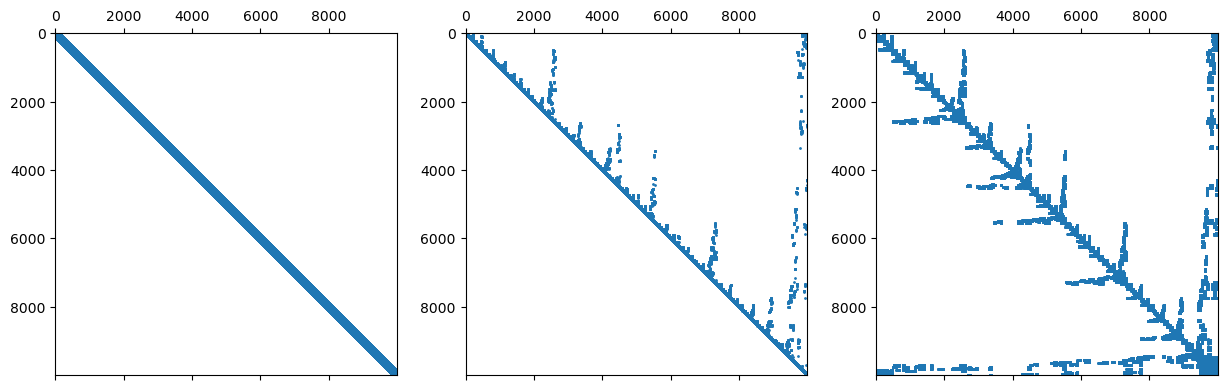

In [35]:
f, ax = plt.subplots(1, 3, figsize=(15,10))
ax[0].spy(A, marker='.', ms=2)
ax[1].spy(B.L + B.U, marker='.', ms=2)
ax[2].spy(C.L + C.U, marker='.', ms=2)

In [39]:
Mz = lambda r: B.solve(r)
Minv = sla.LinearOperator(A.shape, Mz)
t = time.time()
Minv.matvec(b)
tspmv = time.time() - t
print("time to solve: %g"%tspmv)

time to solve: 0.00100017


In [45]:
res0 = []
t = time.time()
x = pyamg.krylov.gmres(A, b, x0=x0, tol=1e-8, restrt=20, maxiter=100, M=None, residuals=res0)
t = time.time() - t
print("time for  gmres: %g"%t)
res1 = []
t = time.time()
x = pyamg.krylov.gmres(A, b, x0=x0, tol=1e-8, restrt=20, maxiter=100, M=Minv, residuals=res1)
t = time.time() - t
print("time for pgmres: %g"%t)

time for  gmres: 0.465899
time for pgmres: 0.486985


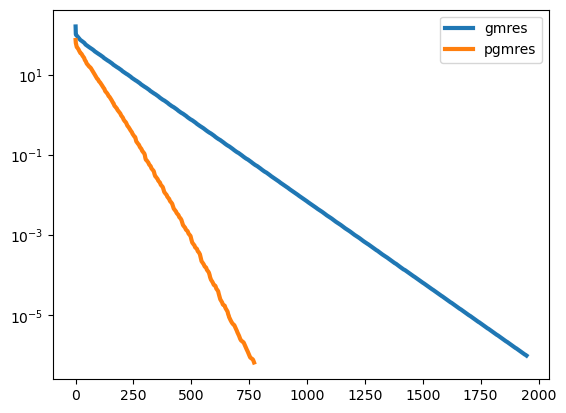

In [46]:
plt.semilogy(res0, lw=3, label='gmres')
# plt.hold(True)
plt.semilogy(res1, lw=3, label='pgmres')
plt.legend()

In [48]:

t = time.time()
prec, prectime  = preconditioner("baseline", A)

x, _, itera = precon_GMRES_restarted(prec, A, b, x0, k_max = 1000, restart = 100)
t = time.time() - t
print("time for  gmres: %g"%t)
print(itera)
t = time.time()
prec, prectime  = preconditioner("ilu", A)

x, _, itera = precon_GMRES_restarted(prec, A, b, x0, k_max = 1000, restart = 100)
t = time.time() - t
print(prectime)
print("time for pgmres: %g"%t)
print(itera)

time for  gmres: 2.64864
573
0.0005535000091185793
time for pgmres: 6.83874
121


We see that we reduce the number of iterations but it takes more time...